This notebook produces the plots for the main text of the photon noise paper.

In [10]:
save_pdf = True
save_eps = True

In [11]:
import os
import pandas as pd
from scipy.constants import h, k as k_B, pi
import matplotlib as mpl
print(mpl.matplotlib_fname())
from kid_readout.analysis import archive, dataframe, plot_dataframe
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams['font.size'] = 11

/home/flanigan/notebooks/mkid/2015_Flanigan/matplotlibrc


In [12]:
bb = pd.DataFrame(np.load('broadband.npy'))
cw = pd.DataFrame(np.load('continuous-wave.npy'))

In [13]:
def common(df, key):
    s = set(df[key])
    if len(s) > 1:
        raise ValueError("Multiple values for {}".format(key))
    else:
        return s.pop()

In [14]:
def float_to_latex(f):
    if np.log10(f) < -15:
        unit = 'aW'
        scale = 1e6
        format_string = '{:.2f} {}'
    elif np.log10(f) < -12:
        unit = 'fW'
        scale = 1e3
        format_string = '{:.0f} {}'
    else:
        unit = 'pW'
        scale = 1
        format_string = '{:.2g} {}'
    return '{:.3g} {}'.format(1e12 * scale * f, unit)

In [15]:
eta_bb = common(bb, 'eta')
B_bb = common(bb, 'B')

eta_cw = common(cw, 'eta')

single_channel = common(bb, 'channel')
#atten = 29
nu_cw = common(cw, 'timestream_mmw_source_freq')
nu_bb = 150e9

In [16]:
noise_colormap = plt.cm.RdYlBu_r
cw_color = 'darkgoldenrod'
bb_color = 'darkgreen'
cw_marker = 's'
bb_marker = 'o'
cw_label = "continuous-wave"  # "c-w {:.0f} GHz".format(1e-9 * cw.timestream_mmw_source_freq.iloc[0])
bb_label = "broadband"  # "bb 140-160 GHz"

Sx_scale = 1e18
noise_ylimits = (Sx_scale * 1e-19, Sx_scale * 3e-15)
noise_xlimits = (1e1, 1e4)

PA_scale = 1e12
X_scale = 1e6
PA_limits = (8e-4, 6e1)
X_limits = (1e-1, 1e3)
NEPA_limits = (1e-18, 1e-15)
PA_line = np.logspace(np.log10(PA_limits[0]), np.log10(PA_limits[1]), 1e3) / PA_scale
to_aWrtHz = 1e18

In [17]:
mappable_cw = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(cw.source_power), max(cw.source_power)),
                                    cmap=noise_colormap)
mappable_cw.set_array(cw.source_power)

mappable_bb = plt.cm.ScalarMappable(matplotlib.colors.LogNorm(min(bb.source_power), max(bb.source_power)),
                                    cmap=noise_colormap)
mappable_bb.set_array(bb.source_power)

# Results

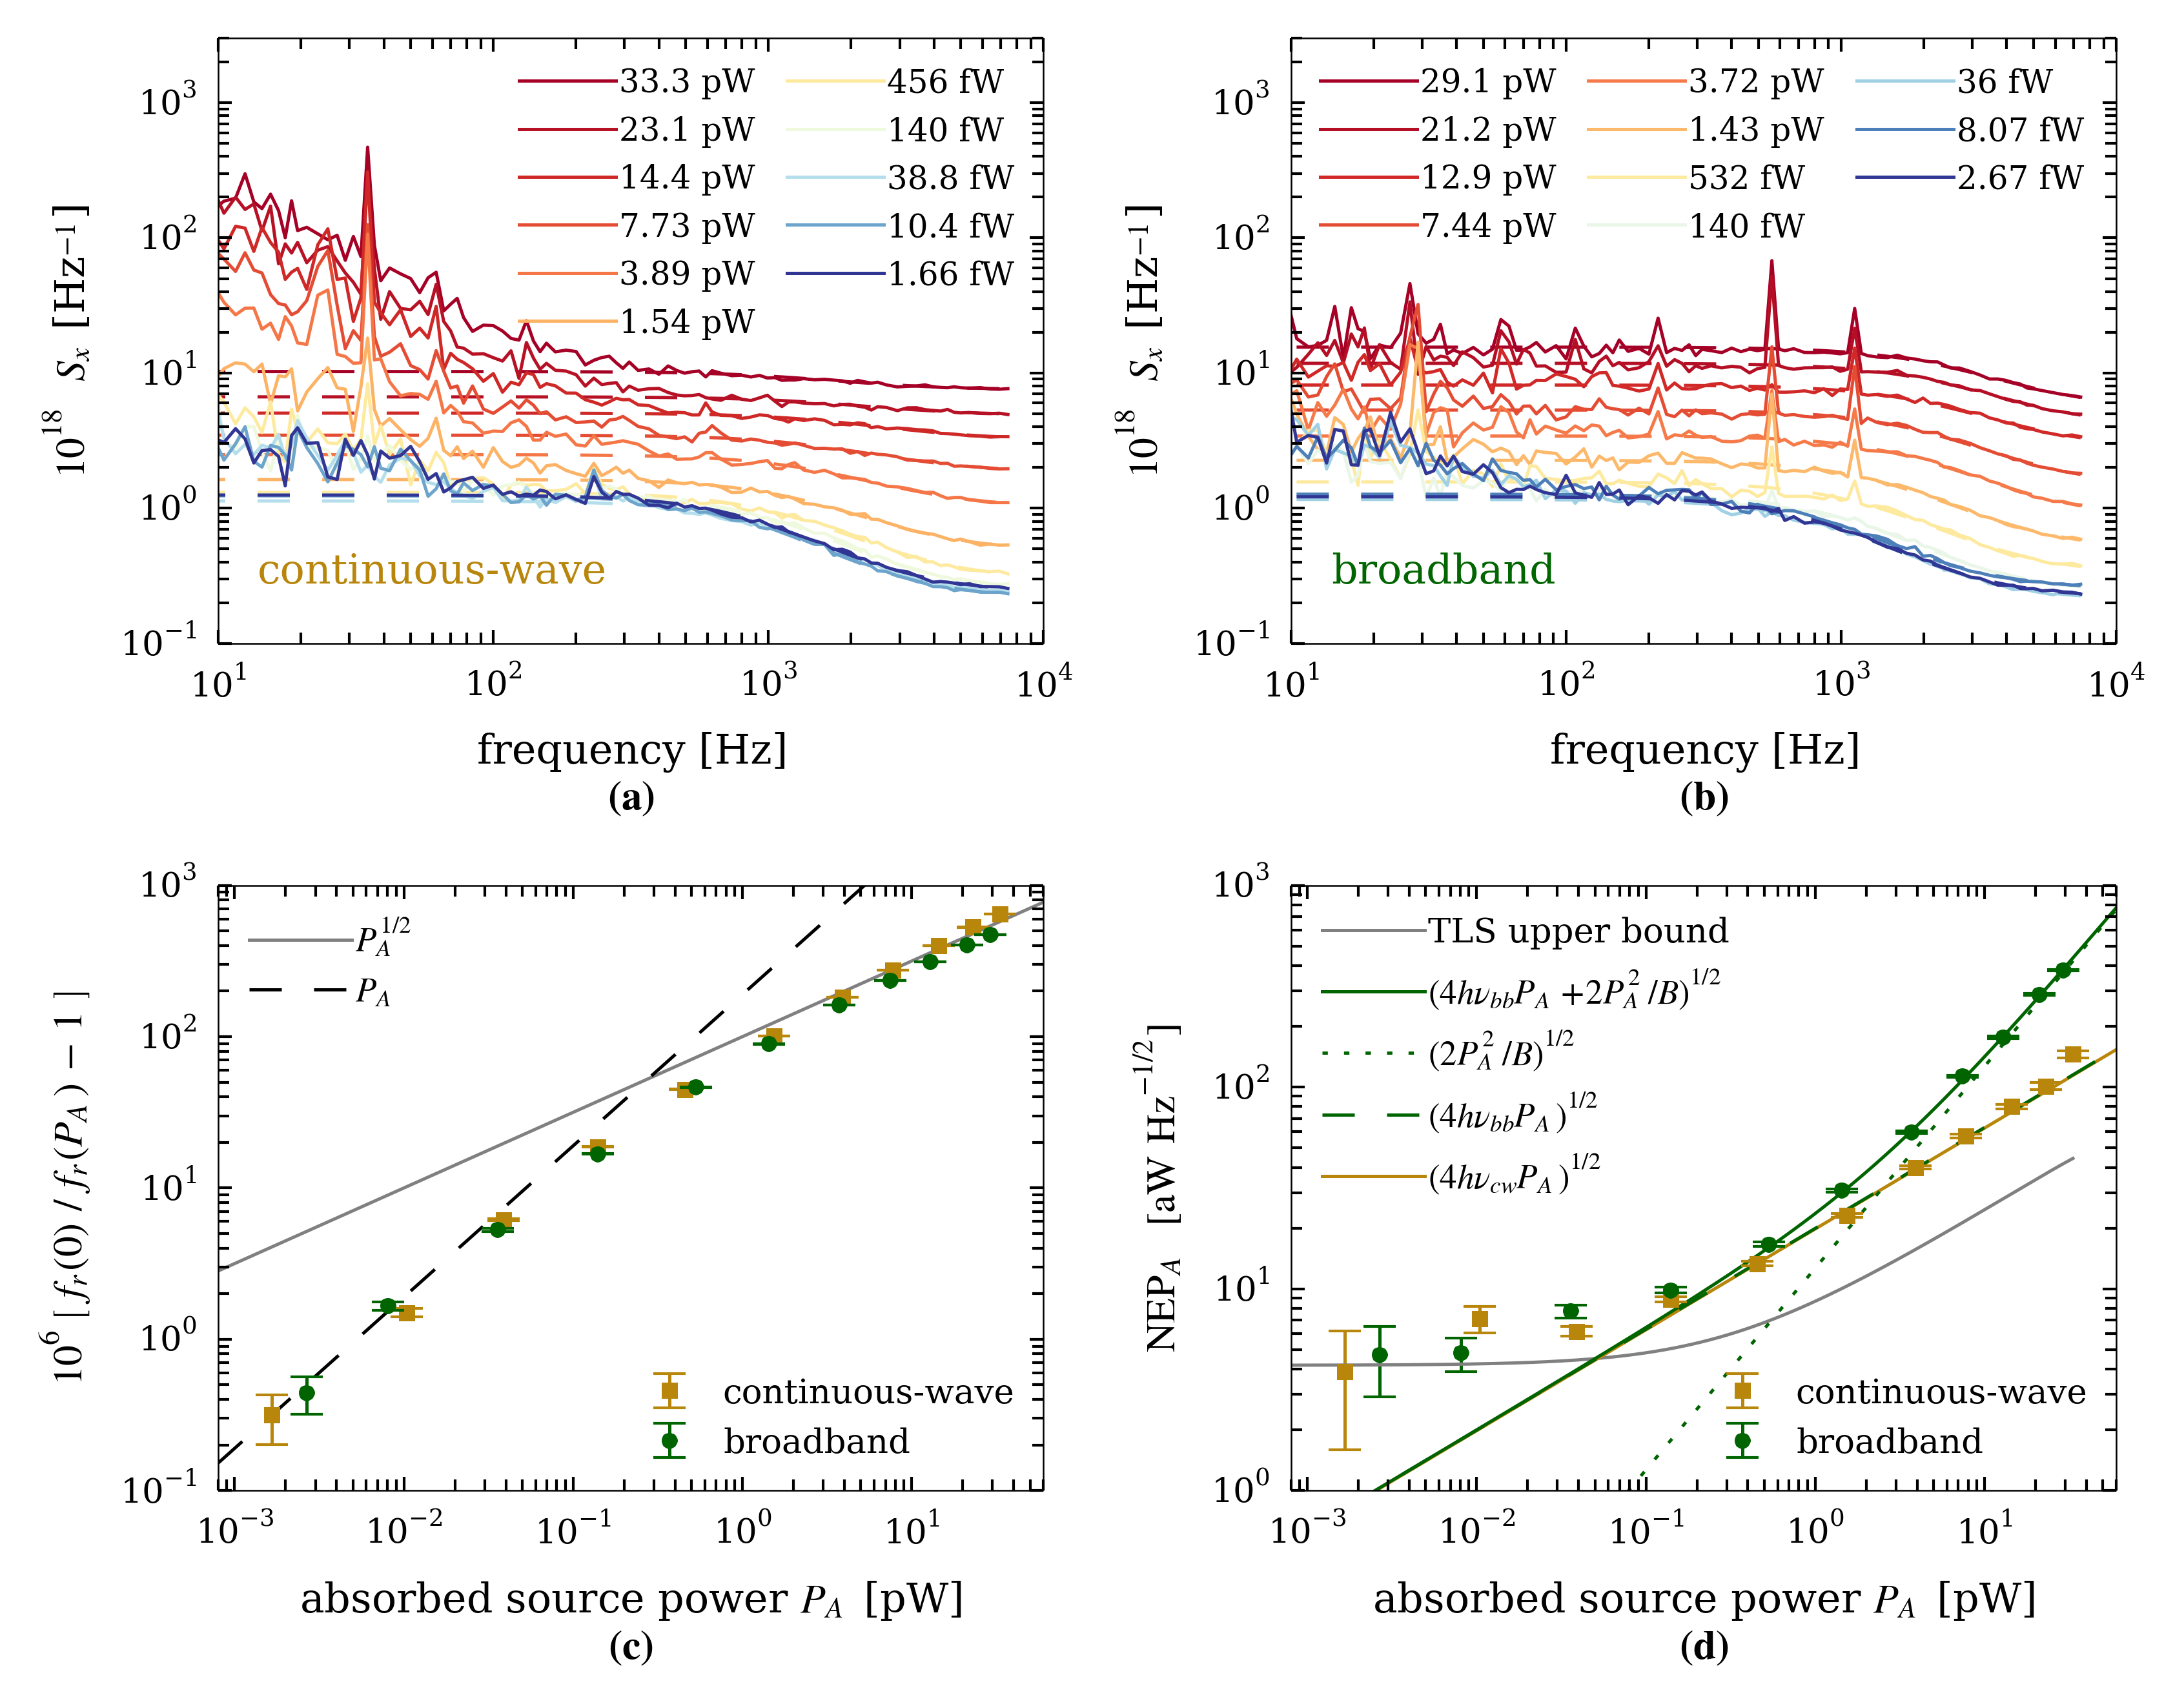

In [18]:
with plt.rc_context({'figure.subplot.wspace': 0.3,
                     'figure.subplot.hspace': 0.4,
#                     'lines.linewidth': 0.8,
                     'legend.fontsize': 'xx-small',
                     }):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))
    (cw_ax, bb_ax, response_ax, nep_ax) = axes.flatten()
    
    for index, row in cw.iterrows():
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_cw.to_rgba(row.source_power), alpha=1,
                     label=float_to_latex(eta_cw * row.source_power))
        cw_ax.loglog(row.pca_freq,
                     Sx_scale * (row.noise_fit_device_noise / (1 + (row.pca_freq / row.noise_fit_fc)**2) +
                                 row.noise_fit_amplifier_noise),
                     '--', color=mappable_cw.to_rgba(row.source_power))
    cw_ax.set_xlabel("frequency [Hz]\n" + r"${\bf(a)}$")
    cw_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    cw_ax.set_xlim(*noise_xlimits)
    cw_ax.set_ylim(*noise_ylimits)
    cw_ax.legend(loc='upper right', ncol=2, fontsize=6)
    cw_ax.text(0.05, 0.1, cw_label, size='x-small', color=cw_color, transform=cw_ax.transAxes)

    # Broadband
    for index, row in bb.iterrows():
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * row.pca_eigvals[1],
                     color=mappable_bb.to_rgba(row.source_power), alpha=1,
                     label=float_to_latex(eta_bb * row.source_power))
        bb_ax.loglog(row.pca_freq,
                     Sx_scale * (row.noise_fit_device_noise / (1 + (row.pca_freq / row.noise_fit_fc)**2) +
                                 row.noise_fit_amplifier_noise),
                     '--', color=mappable_bb.to_rgba(row.source_power))
    bb_ax.set_xlabel("frequency [Hz]\n" + r"${\bf(b)}$")
    bb_ax.set_ylabel("$10^{18} \; S_x$ [Hz$^{-1}$]")
    bb_ax.set_xlim(*noise_xlimits)
    bb_ax.set_ylim(*noise_ylimits)
    bb_ax.legend(loc='upper left', ncol=3, fontsize=6)
    bb_ax.text(0.05, 0.1, bb_label, size='x-small', color=bb_color, transform=bb_ax.transAxes)

    # Response
    response_ax.plot(PA_scale * PA_line,
                     1.0e2 * (PA_scale * PA_line)**(1/2),
                     '-', color='gray', label='$P_A^{1/2}$')
    response_ax.plot(PA_scale * PA_line,
                     1.9e2 * (PA_scale * PA_line)**1,
                     '--', color='black', label='$P_A$')

    for df, eta, color, marker, label in zip((cw, bb), (eta_cw, eta_bb),
                                             (cw_color, bb_color), (cw_marker, bb_marker),
                                             (cw_label, bb_label)):
        response_ax.errorbar(PA_scale * eta * df.source_power,
                             X_scale * df.source_power_X,
                             yerr=X_scale * df.source_power_X_err,
                             marker=marker, color=color, label=label,
                             linestyle='none', markeredgecolor='none')

    response_ax.set_xlim(*PA_limits)
    response_ax.set_ylim(*X_limits)
    response_ax.set_xscale('log')
    response_ax.set_yscale('log', nonposy='clip')
    response_ax.set_ylabel(r'$10^6 \left[ \, f_r(0) \, / \, f_r(P_A) \, - \, 1 \, \right]$')
    response_ax.set_xlabel("absorbed source power $P_A$ [pW]\n"  + r"${\bf(c)}$")
    response_handles, response_labels = response_ax.get_legend_handles_labels()
    response_ax.add_artist(response_ax.legend(response_handles[:2], response_labels[:2], loc='upper left'))
    response_ax.legend(response_handles[2:], response_labels[2:], loc='lower right')

    # NEP
    NEP_cw = eta_cw * cw.source_power_fd_NEP2_device**(1/2)
    NEP_bb = eta_bb * bb.source_power_fd_NEP2_device**(1/2)

    # TLS noise
    """
    PS_tls = np.logspace(np.log10(np.min(bb.source_power)) - 1,
                         np.log10(np.max(bb.source_power)),
                         1e3)
    tls_poly = np.polyfit(bb.source_power, bb.source_power_fd_NEP2_TLS, 3)
    nep_ax.plot(PA_scale * eta_bb * PS_tls,
                to_aWrtHz * eta_bb * np.polyval(tls_poly, PS_tls)**(1/2),
                '-', color='gray', label='TLS upper bound')

    """
    # 0
    PS_tls = np.logspace(np.log10(np.min(cw.source_power)) - 1,
                         np.log10(np.max(cw.source_power)),
                         1e3)
    tls_poly = np.polyfit(cw.source_power, cw.source_power_fd_NEP2_TLS, 3)
    nep_ax.plot(PA_scale * eta_cw * PS_tls,
                to_aWrtHz * eta_cw * np.polyval(tls_poly, PS_tls)**(1/2),
                '-', color='gray', label='TLS upper bound')
    
    # 1
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_cw * PA_line)**(1/2),
                '-', color=cw_color, label=r'$(4 h \nu_{cw} P_A)^{1/2}$')
    # 2
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_bb * PA_line)**(1/2),
                '--', color=bb_color, label=r'$(4 h \nu_{bb} P_A)^{1/2}$')
    # 3
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (2 * PA_line**2 / B_bb)**(1/2),
                ':', color=bb_color, label=r'$(2 P_A^2 / B)^{1/2}$')
    # 4
    nep_ax.plot(PA_scale * PA_line,
                to_aWrtHz * (4 * h * nu_bb * PA_line + 2 * PA_line**2 / B_bb)**(1/2),
                '-', color=bb_color, label=r'$(4 h \nu_{bb} P_A + 2 P_A^2 / B)^{1/2}$')
    
    nep_ax.errorbar(PA_scale * eta_cw * cw.source_power,
                    to_aWrtHz * NEP_cw,
                    yerr=(to_aWrtHz * NEP_cw *
                          (1/2) * (cw.source_power_fd_NEP2_device_err / cw.source_power_fd_NEP2_device)),
                    marker=cw_marker, markeredgecolor='none', linestyle='none',
                    color=cw_color, label=cw_label)

    nep_ax.errorbar(PA_scale * eta_bb * bb.source_power,
                    to_aWrtHz * NEP_bb,
                    yerr=(to_aWrtHz * NEP_bb *
                          (1/2) * (bb.source_power_fd_NEP2_device_err / bb.source_power_fd_NEP2_device)),
                    marker=bb_marker, markeredgecolor='none', linestyle='none',
                    color=bb_color, label=bb_label)

    nep_ax.set_xlabel('absorbed source power $P_A$ [pW]\n' + r'${\bf(d)}$')
    nep_ax.set_ylabel(r'$\mathrm{NEP}_A \; [\mathrm{aW} \, \mathrm{Hz}^{-1/2}]$')
    nep_ax.set_xlim(*PA_limits)
    nep_ax.set_ylim(to_aWrtHz * NEPA_limits[0], to_aWrtHz * NEPA_limits[1]);
    nep_ax.set_yscale('log', nonposy='clip')
    nep_ax.set_xscale('log')
    nep_handles, nep_labels = nep_ax.get_legend_handles_labels()
    order = [0, 4, 3, 2, 1]
    nep_ax.add_artist(nep_ax.legend([nep_handles[n] for n in order],
                                    [nep_labels[n] for n in order], loc='upper left'))
    nep_ax.legend(nep_handles[5:7], nep_labels[5:7], loc='lower right')

if save_pdf:
    fig.savefig('results.pdf')
if save_eps:
    fig.savefig('results.eps')

# Support

This section contains plots and calculations that support values quoted in the text.

In [23]:
print("Continuous-wave: {:.3f} MHz".format(cw.f_r.max()))
print("Broadband: {:.3f} MHz".format(bb.f_r.max()))

Continuous-wave: 164.088 MHz
Broadband: 164.088 MHz


In [24]:
cw.power_dbm.iloc[0]

-100.04119982655925

In [25]:
bb.power_dbm.iloc[0]

-100.04119982655925